In [2]:
import pandas as pd
import numpy as np
import pickle 
from datetime import date, timedelta, datetime
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report

In [3]:
# Load data
data_file = "./data/WA_Fn-UseC_-HR-Employee-Attrition.csv"
data_orig = pd.read_csv(data_file)

In [4]:
# Top 5 rows
data_orig.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [5]:
# Find any column with null value
data_orig.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [5]:
''' Drop irrelevant features: 
    - "StandardHours" all 40
    - "Over18" all 1
    - "EmployeeCount" all 1
    - "EmployeeNumber" incremental integar
'''
data = data_orig.drop(['StandardHours', 'Over18', 
                       'EmployeeCount', 'EmployeeNumber'], axis=1)

# Data visualization

## Demographic-related features
Age, Gender, Education, EducationField, MaritalStatus

Average age of employees left: 33.61
Average age of employees stayed: 37.56


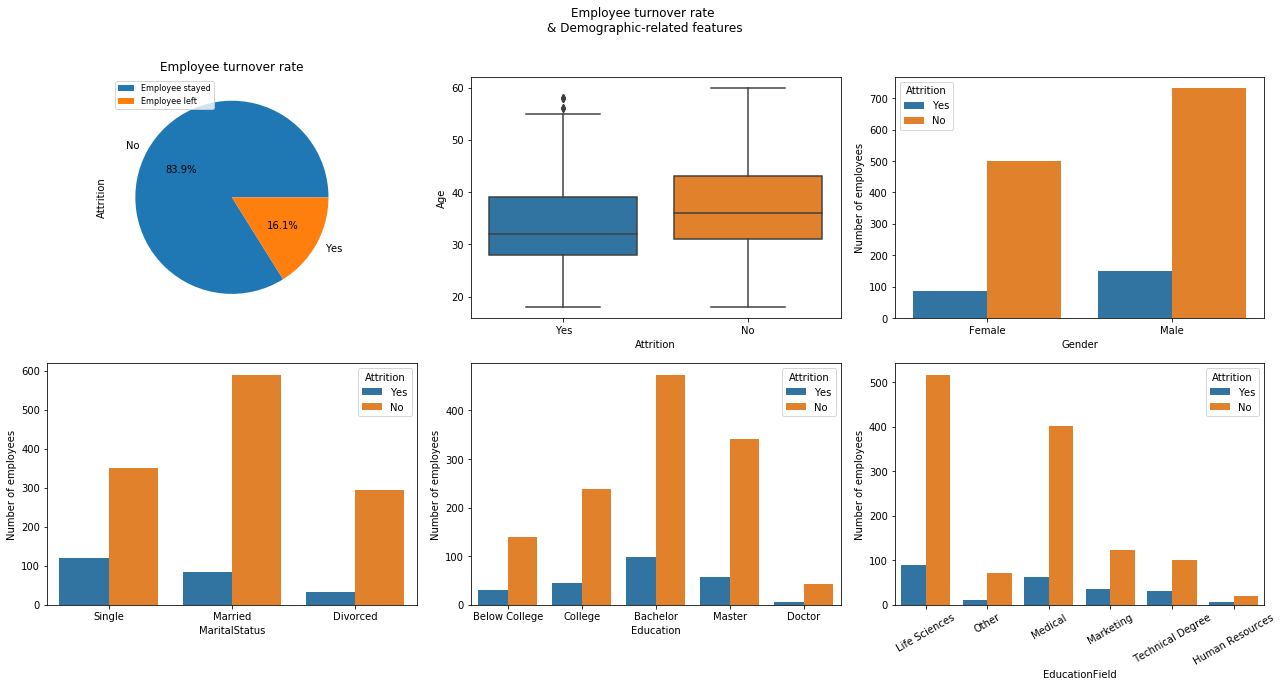

In [6]:
fig, axes = plt.subplots(2,3,figsize=(18,10))
fig.suptitle('Employee turnover rate \n& Demographic-related features')
ax = data['Attrition'].value_counts().plot.pie(autopct='%1.1f%%', textprops={'fontsize': 10}, ax=axes[0,0])
ax.set_title('Employee turnover rate', fontsize=12)
ax.legend(loc=2, labels=['Employee stayed', 'Employee left'], prop={'size':8})
print('Average age of employees left: {:.2f}'.format(data[data['Attrition']=="Yes"]['Age'].mean()))
print('Average age of employees stayed: {:.2f}'.format(data[data['Attrition']=="No"]['Age'].mean()))
ax = sns.boxplot(x='Attrition', y='Age', data=data,ax=axes[0,1])
ax.set_ylabel('Age')
ax = sns.countplot(x='Gender',hue='Attrition',data=data,ax=axes[0,2])
ax.set_ylabel('Number of employees')
ax = sns.countplot(x='MaritalStatus',hue='Attrition',data=data,ax=axes[1,0])
ax.set_ylabel('Number of employees')
ax = sns.countplot(x='Education',hue='Attrition',data=data,ax=axes[1,1])
ax.set_ylabel('Number of employees')
ax.set_xticklabels({1:'Below College', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'}.values())
ax = sns.countplot(x='EducationField',hue='Attrition',data=data,ax=axes[1,2])
ax.set_ylabel('Number of employees')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

## Work-related features

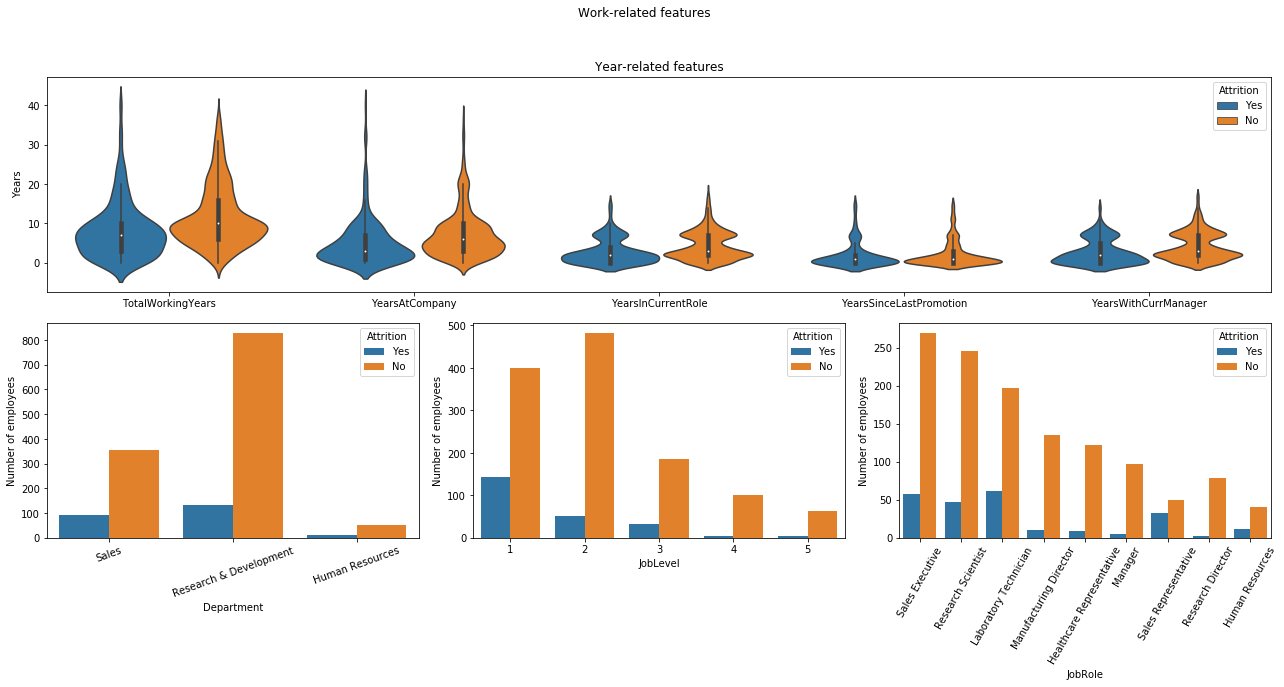

In [9]:
fig = plt.figure(figsize=(18,10))
fig.suptitle('Work-related features')
row = 2
col = 3
ax = plt.subplot2grid((row,col),(0,0), rowspan=1, colspan=col)
# 2.1 Year-related features
data_tmp = data[['Attrition', 'TotalWorkingYears', 
                 'YearsAtCompany', 'YearsInCurrentRole', 
                 'YearsSinceLastPromotion', 'YearsWithCurrManager']]
sns.violinplot(x="variable", y="value", hue='Attrition',
            data=pd.melt(data_tmp,'Attrition'), ax=ax)
ax.set_title('Year-related features', fontsize=12)
ax.set_ylabel('Years')
ax.set_xlabel('')
# 2.2 Categorical features
ax = plt.subplot2grid((row,col),(1,0), rowspan=1, colspan=1)
ax = sns.countplot(data=data,x='Department',hue='Attrition', ax=ax)
ax.set_ylabel('Number of employees')
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)
ax = plt.subplot2grid((row,col),(1,1), rowspan=1, colspan=1)
ax = sns.countplot(data=data,x='JobLevel',hue='Attrition', ax=ax)
ax.set_ylabel('Number of employees')
ax = plt.subplot2grid((row,col),(1,2), rowspan=1, colspan=1)
ax = sns.countplot(data=data,x='JobRole',hue='Attrition', ax=ax)
ax.set_ylabel('Number of employees')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])


## Compensation-related features
Attrition, DailyRate, HourlyRate, MonthlyIncome, MonthlyRate, PercentSalaryHike, StockOptionLevel

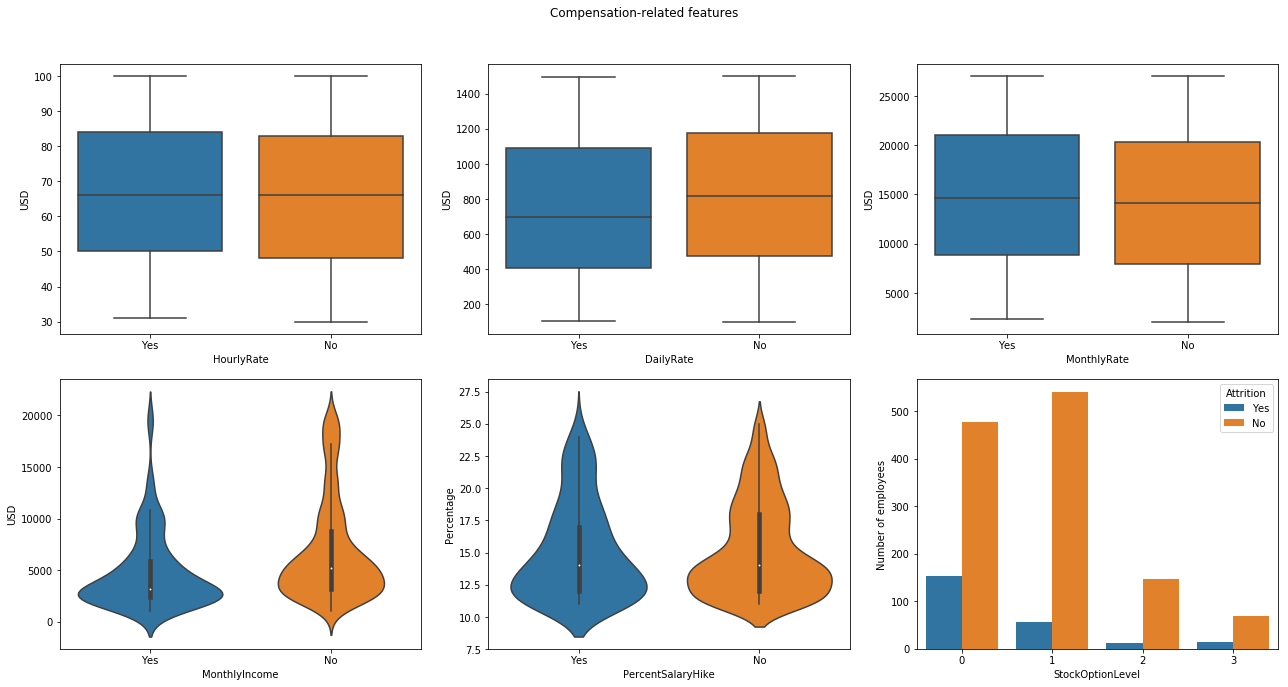

In [9]:
fig, axes = plt.subplots(2,3,figsize=(18,10))
fig.suptitle('Compensation-related features')
ax = sns.boxplot(x='Attrition', y='HourlyRate', data=data,ax=axes[0,0])
ax.set_ylabel('USD')
ax.set_xlabel('HourlyRate')
ax = sns.boxplot(x='Attrition', y='DailyRate',data=data,ax=axes[0,1])
ax.set_ylabel('USD')
ax.set_xlabel('DailyRate')
ax = sns.boxplot(x='Attrition', y='MonthlyRate',data=data,ax=axes[0,2])
ax.set_ylabel('USD')
ax.set_xlabel('MonthlyRate')
ax = sns.violinplot(x='Attrition', y='MonthlyIncome',data=data,ax=axes[1,0])
ax.set_ylabel('USD')
ax.set_xlabel('MonthlyIncome')
ax = sns.violinplot(x='Attrition', y='PercentSalaryHike',data=data,ax=axes[1,1])
ax.set_ylabel('Percentage')
ax.set_xlabel('PercentSalaryHike')
ax = sns.countplot(x='StockOptionLevel',data=data, hue='Attrition', ax=axes[1,2])
ax.set_ylabel('Number of employees')
ax.set_xlabel('StockOptionLevel')
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

## Employee-satisfaction-related features
EnvironmentSatisfaction 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

JobInvolvement 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

RelationshipSatisfaction 1 'Low' 2 'Medium' 3 'High' 4 'Very High'

PerformanceRating 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'

WorkLifeBalance 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

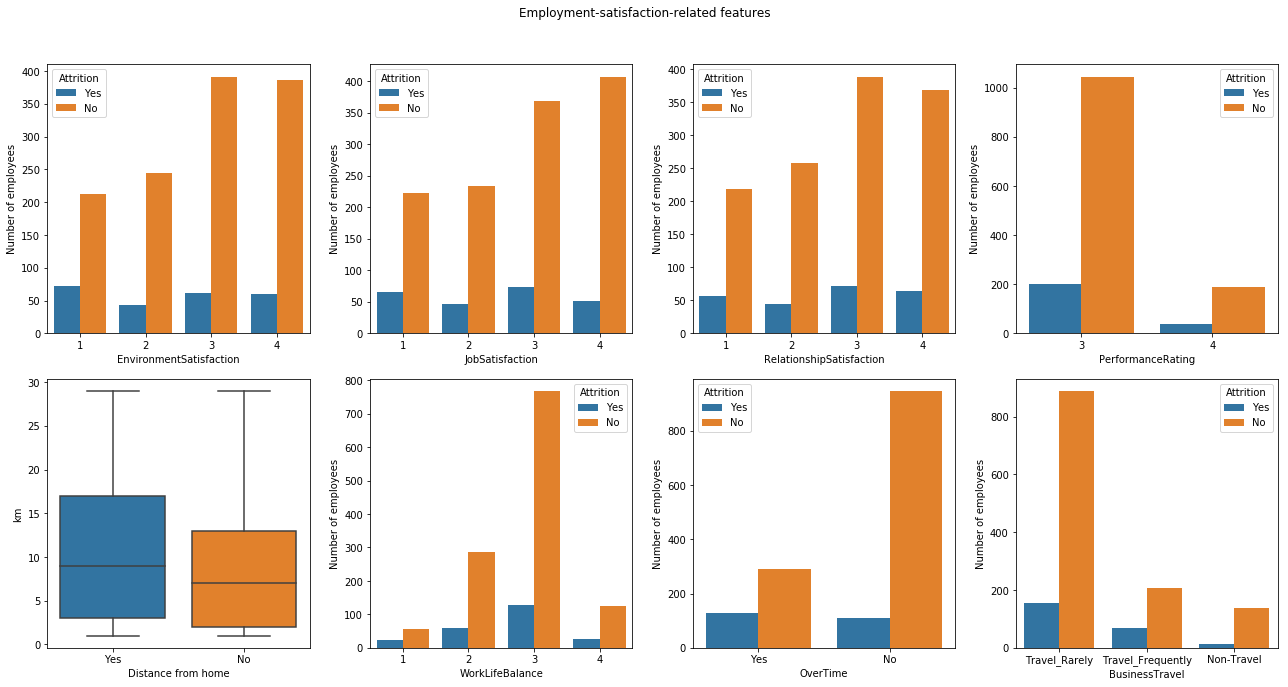

In [10]:
fig, axes = plt.subplots(2,4,figsize=(18,10))
fig.suptitle('Employment-satisfaction-related features')
ax = sns.countplot(data=data,x='EnvironmentSatisfaction',hue='Attrition', ax=axes[0,0])
ax.set_ylabel('Number of employees')
ax = sns.countplot(data=data,x='JobSatisfaction',hue='Attrition', ax=axes[0,1])
ax.set_ylabel('Number of employees')
ax = sns.countplot(data=data,x='RelationshipSatisfaction',hue='Attrition', ax=axes[0,2])
ax.set_ylabel('Number of employees')
ax = sns.countplot(data=data,x='PerformanceRating',hue='Attrition', ax=axes[0,3])
ax.set_ylabel('Number of employees')
ax = sns.boxplot(x='Attrition', y='DistanceFromHome',data=data,ax=axes[1,0])
ax.set_ylabel('km')
ax.set_xlabel('Distance from home')
ax = sns.countplot(data=data,x='WorkLifeBalance',hue='Attrition', ax=axes[1,1])
ax.set_ylabel('Number of employees')
ax = sns.countplot(data=data,x='OverTime',hue='Attrition', ax=axes[1,2])
ax.set_ylabel('Number of employees')
ax = sns.countplot(data=data,x='BusinessTravel',hue='Attrition', ax=axes[1,3])
ax.set_ylabel('Number of employees')
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

# Train Model

In [10]:
# Convert Attrition (the label column) to 1 and 0
yes_no_map = {'Yes':1, 'No':0}
data["Attrition"] = data["Attrition"].apply(lambda x: yes_no_map[x])

In [11]:
# Convert categorical columns
data = pd.get_dummies(data, columns=['BusinessTravel','Department',
            'EducationField','Gender','JobRole','MaritalStatus','OverTime'])

In [12]:
# Separate label from features
y = data['Attrition']
X = data.drop('Attrition', axis = 1)

In [13]:
# Split train and test data in a stratified fashion (for imbalanced dataset)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, 
                                                    random_state=4, stratify=y.values)

## Decision Tree Classification

In [85]:
# shuffling for cross-validation
cv_sets = ShuffleSplit(random_state = 4)

In [86]:
dt_classifier = DecisionTreeClassifier(random_state=9) 
dt_parameters = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [3, 4, 5],
                  'max_features': [3, 4, 5], #number of features to consider for the best split
                  'class_weight':[{0:2,1:8},{0:1,1:1}]} # weights associated with classes
scorer = make_scorer(accuracy_score)
dt_grid_search = GridSearchCV(dt_classifier, 
                              dt_parameters, 
                              scoring = scorer, 
                              cv = cv_sets,
                              verbose=1)

In [87]:
start = time() # start time
dt_grid_fit = dt_grid_search.fit(train_X, train_y.values)
dt_best = dt_grid_search.best_estimator_
end = time() # end time
# Calculate training time
dt_time = (end-start)/60.
print('---------------------------------------')
print('Took {0:.2f} minutes to find optimized parameters for Decision Tree model'.format(dt_time))
print('Best parameters for Decision Tree model: {}'.format(dt_grid_fit.best_params_))
print('---------------------------------------')

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


---------------------------------------
Took 0.04 minutes to find optimized parameters for Decision Tree model
Best parameters for Decision Tree model: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'splitter': 'random'}
---------------------------------------


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    2.3s finished


In [88]:
# Accuracy on test prediction
test_pred = dt_best.predict(test_X)
print('Accuracy score: {0:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y,test_pred))

Accuracy score: 0.8333
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       247
           1       0.25      0.02      0.04        47

   micro avg       0.83      0.83      0.83       294
   macro avg       0.55      0.50      0.47       294
weighted avg       0.75      0.83      0.77       294



## Random Forest Classification

In [89]:
# shuffling for cross-validation
cv_sets = ShuffleSplit(random_state = 4) 

In [57]:
rf_regressor = RandomForestClassifier(random_state=21, n_jobs=-1)
# Random grid search on hyperparameters
rf_parameters = {'n_estimators':[10, 50, 60], 
                 'min_samples_leaf':[1, 2, 3], 
                 'max_depth':[10, 12, 14],
                 'min_impurity_decrease':[0.0],
                 'min_samples_split':[2, 4]}
scorer = make_scorer(accuracy_score)
n_iter = 36
rf_grid_search = RandomizedSearchCV(rf_regressor, 
                              rf_parameters, 
                              n_iter = n_iter, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 50)

In [90]:
start = time() # start time
rf_grid_fit = rf_grid_search.fit(train_X, train_y)
rf_best = rf_grid_search.best_estimator_
end = time() # end time
# Calculate training time
rf_time = (end-start)/60.
print('---------------------------------------')
print('Took {0:.2f} minutes to find optimized parameters for RF model'.format(rf_time))
print('Best parameters for RF model: {}'.format(rf_grid_fit.best_params_))
print('---------------------------------------')

---------------------------------------
Took 0.40 minutes to find optimized parameters for RF model
Best parameters for RF model: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_depth': 14}
---------------------------------------


In [91]:
# Accuracy on test prediction
test_pred = rf_best.predict(test_X)
print('Accuracy score: {0:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y,test_pred))

Accuracy score: 0.8707
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       247
           1       0.85      0.23      0.37        47

   micro avg       0.87      0.87      0.87       294
   macro avg       0.86      0.61      0.65       294
weighted avg       0.87      0.87      0.84       294



## XGBoost Classification

In [68]:
# shuffling for cross-validation
cv_sets = ShuffleSplit(random_state = 4)

In [81]:
xgb_classifier = xgb.XGBClassifier(random_state=29, n_jobs=-1)
xgb_parameters = {'objective': ['binary:logistic'],
                  'n_estimators': [80, 100, 120],
                  'learning_rate': [0.01, 0.1, 1],
                  'gamma': [0, 0.01, 0.2],
                  'reg_lambda': [0.1, 1],
                  'max_depth': [3, 5], # Max depth of tree. Deeper -> overfitting
                  'subsample': [0.5, 1.0], # Subsample ratio of training instances
                  'colsample_bytree': [0.8, 1], # Subsample ratio of columns of each tree
                  'silent': [1] # Printing running msg
                  }
scorer = make_scorer(accuracy_score)
n_iter = 36
xgb_grid_search = RandomizedSearchCV(xgb_classifier, 
                              xgb_parameters, 
                              n_iter = n_iter, 
                              scoring = scorer, 
                              cv = cv_sets,
                              verbose=1,
                              random_state= 50)

In [82]:
start = time() # start time
xgb_grid_fit = xgb_grid_search.fit(train_X, train_y.values)
xgb_best = xgb_grid_search.best_estimator_
end = time() # end time
# Calculate training time
xgb_time = (end-start)/60.
print('---------------------------------------')
print('Took {0:.2f} minutes to find optimized parameters for XGB model'.format(xgb_time))
print('Best parameters for XGB model: {}'.format(xgb_grid_fit.best_params_))
print('---------------------------------------')

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


---------------------------------------
Took 0.87 minutes to find optimized parameters for XGB model
Best parameters for XGB model: {'subsample': 0.5, 'silent': 1, 'reg_lambda': 1, 'objective': 'binary:logistic', 'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
---------------------------------------


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   51.7s finished


In [83]:
# Accuracy on test prediction
test_pred = xgb_best.predict(test_X)
print('Accuracy score: {0:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y,test_pred))

Accuracy score: 0.8844
              precision    recall  f1-score   support

           0       0.90      0.98      0.93       247
           1       0.76      0.40      0.53        47

   micro avg       0.88      0.88      0.88       294
   macro avg       0.83      0.69      0.73       294
weighted avg       0.87      0.88      0.87       294



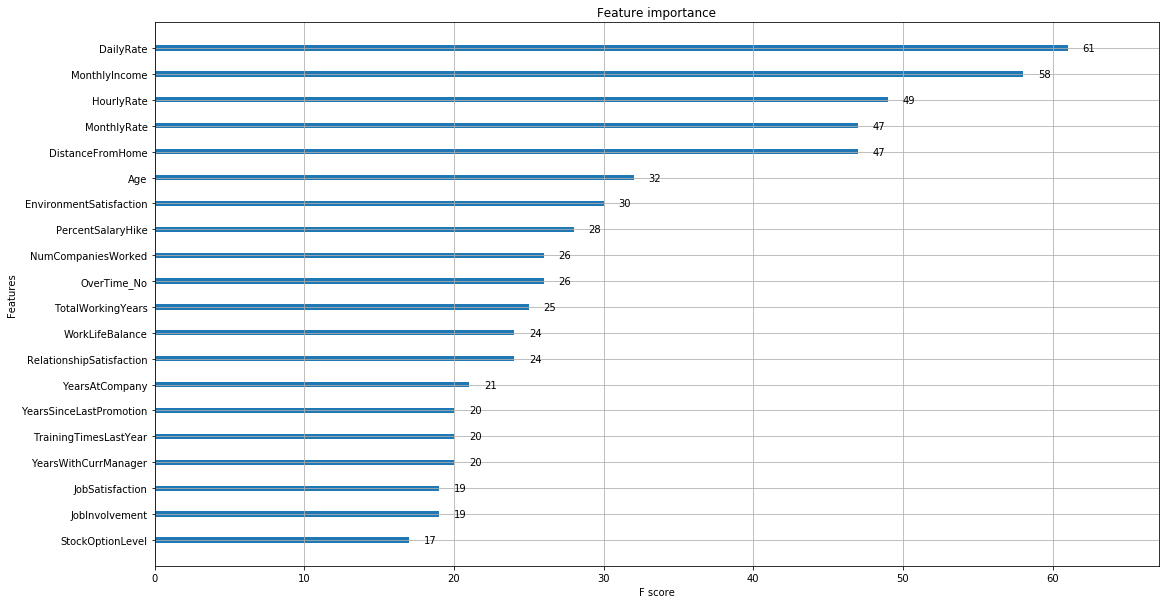

In [84]:
# Plot important feature scores
fig, ax = plt.subplots(figsize=(18,10))
xgb.plot_importance(xgb_best, max_num_features=20, ax=ax)